# CS224 - Winter 2023 - PROGRAMMING ASSIGNMENT 3 - DNN

**Due**: March 22, 2023 @ 11:59pm PDT

**Maximum points**: 15

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Ankith Vijay
  </br>
  <b>Student ID Number</b>:  862394125
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

<div style="padding: 15px; color: #8a6d3b; background-color: #fcf8e3; border: 1px solid #faebcc; border-radius: 5px;">
<b><font size=+2>Academic Integrity</font></b></br> 
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TA, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources. The UCR Academic Integrity policies are available at <a href="http://conduct.ucr.edu/policies/academicintegrity.html" target="_blank">http://conduct.ucr.edu/policies/academicintegrity.html</a>.
</div>

# Overview 
In this assignment you will extract the Deep Convolutional Neural Network features of a dataset(Question 1), implement multinomial logistic regression(Question 2) and ROC curve(Question 3).  

For this assignment we will use the functionality of [PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), [Numpy](http://www.numpy.org/), and [Matplotlib](https://matplotlib.org/).

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, **please ask**. 

Before you start, make sure you have installed all those packages in your local Jupyter instance.


Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the code marked `TODO` and answer descriptive/derivation questions.

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import scipy.io as sio

import matplotlib.pyplot as plt

DO **NOT** MODIFY ANYTHING IF NOT MENTIONED.

# **Question 1: DNN [6 points]**
In this problem, you are required to extract the Deep Convolutional Neural Network (CNN)
features for a dataset. 

The dataset provided is the [**MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) dataset.

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



You need to extract features from these images using the [**ResNet-50**](https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/) architecture available in PyTorch.

You need to fill in the function named `extract`, which loads the images, extracts the features and appends them to the feature list along with the corresponding labels. The output of this code is the file `'mnist_train.mat` and `mnist_test.mat`, which are to be used in the next problem. This file should have

1. `features` of dimension $m\times n$, where $m=60000$ is the number of images and $n=2048$ is the feature dimension obtained using ResNet-50.
1.  `labels` is a vector of length $m$ containing labels from 0 to 9 for the 10 categories.

Some portions of the code is already filled in for convenience. Please do **not** modify anything if not mentioned.



In [6]:
def extract(dataset, filename):
    features = []
    labels = []

    transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    # TODO: get ResNet-50 from PyTorch
    ext = models.resnet50(pretrained=True)
    ext = nn.Sequential(*list(ext.children())[:-1])
    ext.eval()

    ext.eval()

    for (_img, label) in dataset:
        # TODO: fill in to load image, preprocess, and extract features
        # the output variable F expected to be the feature of the image of dimension (2048,)

        img = transform_test(_img).unsqueeze(0)
        with torch.no_grad():
            feature = ext(img).squeeze().numpy()
        features.append(feature)
        labels.append(label)
        
    sio.savemat(filename, mdict={'features': features, 'labels': labels})

Run the code below to get extracted features and labels of MNIST dataset, and then save it to `.mat` file. (This might take a while.) 

You do **not** need to submit the `.mat` file along with the PDF file.

In [5]:
extract(mnist_trainset, 'mnist_train.mat')
extract(mnist_testset, 'mnist_test.mat')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# **Question 2: Multinomial Logistic Regression [6 points]**
In this problem, you will implement the multinomial logistic regression using the extracted features and labels in Question 1. 

You should use variables `trfeature` and `trlabel` for training and `tefeature` and `telabel` for testing. 

Please remember to map the labels properly for testing. You need to fill in the function named `apply_gradient`, which returns the updated parameter $\theta$ after a single pass of gradient descent using the given data points and labels. You also need to fill up certain the portions as mentioned in function `mlr`.


- Using built-in functions like `sklearn.linear_model.LogisticRegression()` will **not** give you any points.
- Please do **not** modify anything if not mentioned.

In [12]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

BATCH_SIZE = 100
LR = 0.01

def get_one_hot(labels):
    cats = np.unique(labels)
    onehot = np.zeros((labels.size, cats.size))
    onehot[np.arange(labels.size), labels] = 1.
    return onehot

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def plot(acc):
    plt.plot(np.arange(len(acc)),  acc, 'b-')
    plt.xlabel('Epoch Number')
    plt.ylabel('Test Accuracy')
    plt.show()


# X is a matrix of size n_samples x n_feature
# L is a vector of size n_samples x n_category
# theta is a matrix of size n_feature x n_category
def apply_gradients(X, L, theta):
    n_samples = X.shape[0]
    n_categories = L.shape[1]
    
    logits = np.dot(X, theta)
    probs = softmax(logits)
    
    gradient = np.dot(X.T, (probs - L)) / n_samples
    new_theta = theta - LR * gradient
    
    return new_theta

def mlr(trfeature, tr_onehot, tefeature, te_onehot):
    m_tr = tr_onehot.shape[0] # number of training samples
    n_features = trfeature.shape[1]
    n_categories = tr_onehot.shape[1]

    theta = np.zeros((n_features, n_categories))
    diff = 1
    epoch = 0

    predonehot = []
    test_accuracy_list = []
    while diff > 1e-10 and epoch < 1000:
        theta_old = theta
        # Train
        for i in range(0, m_tr, BATCH_SIZE):
            endpos = min(m_tr, i+BATCH_SIZE-1)
            theta = apply_gradients(trfeature[i:endpos,:], tr_onehot[i:endpos,:], theta)
        
        diff = np.linalg.norm(theta_old-theta)

        # Predict on the test dataset
        logits = np.dot(tefeature, theta)
        pred_probs = softmax(logits)
        predonehot = np.argmax(pred_probs, axis=1)

        test_accuracy = np.mean(predonehot == telabel)
        test_accuracy_list.append(test_accuracy)

        epoch += 1
        # Update learning rate if you want

    plot(test_accuracy_list)

    print('Test Accuracy: %.5f'%(test_accuracy_list[-1]))

    return pred_probs

Run the code below, check the accuracy plot, and report the test accuracy you obtain.

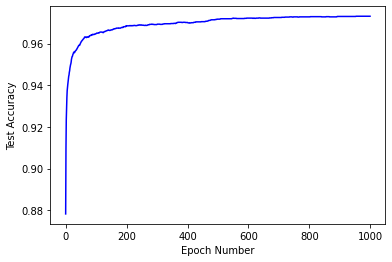

Test Accuracy: 0.97310


In [13]:
# get the extracted features from Question 1
trmat = sio.loadmat('mnist_train.mat')
temat = sio.loadmat('mnist_test.mat')

trfeature, trlabel = trmat['features'], trmat['labels']
tefeature, telabel = temat['features'], temat['labels']

teonehot = get_one_hot(telabel)
# fit multinomial logistic regression
# we will need the variable predonehot for next question
predonehot = mlr(trfeature, get_one_hot(trlabel), tefeature, teonehot)

# **Question 3: ROC [3 points]**
In this problem, you need to implement the Receiver Operating Characteristics (ROC) curve. The output of the function `getROC` should be `TPR`, `FPR` representing True Positive Rate and False Positive Rate respectively.

- Using built-in functions like `sklearn.metrics.roc_curve()` will **not** give you any points.

In [14]:
def getROC(pred, gt):

    sorted_idx = np.argsort(pred)[::-1]
    sorted_gt = gt[sorted_idx]


    TPR = [0.]
    FPR = [0.]


    num_pos = np.sum(gt == 1)
    num_neg = np.sum(gt == 0)

    for i in range(len(sorted_gt)):
        if sorted_gt[i] == 1:

            TPR.append(TPR[-1]+1./num_pos)
            FPR.append(FPR[-1])
        else:

            FPR.append(FPR[-1]+1./num_neg)
            TPR.append(TPR[-1])

    return TPR, FPR


Run the code below to plot the ROC you got for the 9-th category.

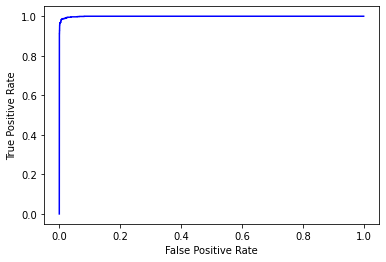

In [15]:
TPR, FPR = getROC(np.array(predonehot)[:, 9], teonehot[:, 9])

plt.plot(FPR, TPR, 'b-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()